In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np

In [2]:
class MNISTDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        target = image.clone()
        # onehot labels
        labels = np.zeros(10)
        labels[label] = 1
        
        return image, target, torch.tensor(labels, dtype=torch.float32)
    
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='mnist_data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='mnist_data', train=False, download=True, transform=transform)

train_noisy_dataset = MNISTDataset(train_dataset)
test_noisy_dataset = MNISTDataset(test_dataset)

train_loader = DataLoader(train_noisy_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_noisy_dataset, batch_size=32, shuffle=False)

In [3]:
T = 150
start = 0.0001
end = 0.03

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

B = torch.linspace(start, end, T).to(device)
B

tensor([1.0000e-04, 3.0067e-04, 5.0134e-04, 7.0201e-04, 9.0268e-04, 1.1034e-03,
        1.3040e-03, 1.5047e-03, 1.7054e-03, 1.9060e-03, 2.1067e-03, 2.3074e-03,
        2.5081e-03, 2.7087e-03, 2.9094e-03, 3.1101e-03, 3.3107e-03, 3.5114e-03,
        3.7121e-03, 3.9128e-03, 4.1134e-03, 4.3141e-03, 4.5148e-03, 4.7154e-03,
        4.9161e-03, 5.1168e-03, 5.3174e-03, 5.5181e-03, 5.7188e-03, 5.9195e-03,
        6.1201e-03, 6.3208e-03, 6.5215e-03, 6.7221e-03, 6.9228e-03, 7.1235e-03,
        7.3242e-03, 7.5248e-03, 7.7255e-03, 7.9262e-03, 8.1268e-03, 8.3275e-03,
        8.5282e-03, 8.7289e-03, 8.9295e-03, 9.1302e-03, 9.3309e-03, 9.5315e-03,
        9.7322e-03, 9.9329e-03, 1.0134e-02, 1.0334e-02, 1.0535e-02, 1.0736e-02,
        1.0936e-02, 1.1137e-02, 1.1338e-02, 1.1538e-02, 1.1739e-02, 1.1940e-02,
        1.2140e-02, 1.2341e-02, 1.2542e-02, 1.2742e-02, 1.2943e-02, 1.3144e-02,
        1.3344e-02, 1.3545e-02, 1.3746e-02, 1.3946e-02, 1.4147e-02, 1.4348e-02,
        1.4548e-02, 1.4749e-02, 1.4950e-

In [4]:
sample_image, target, label = next(iter(train_loader))
sample_image = sample_image[0]

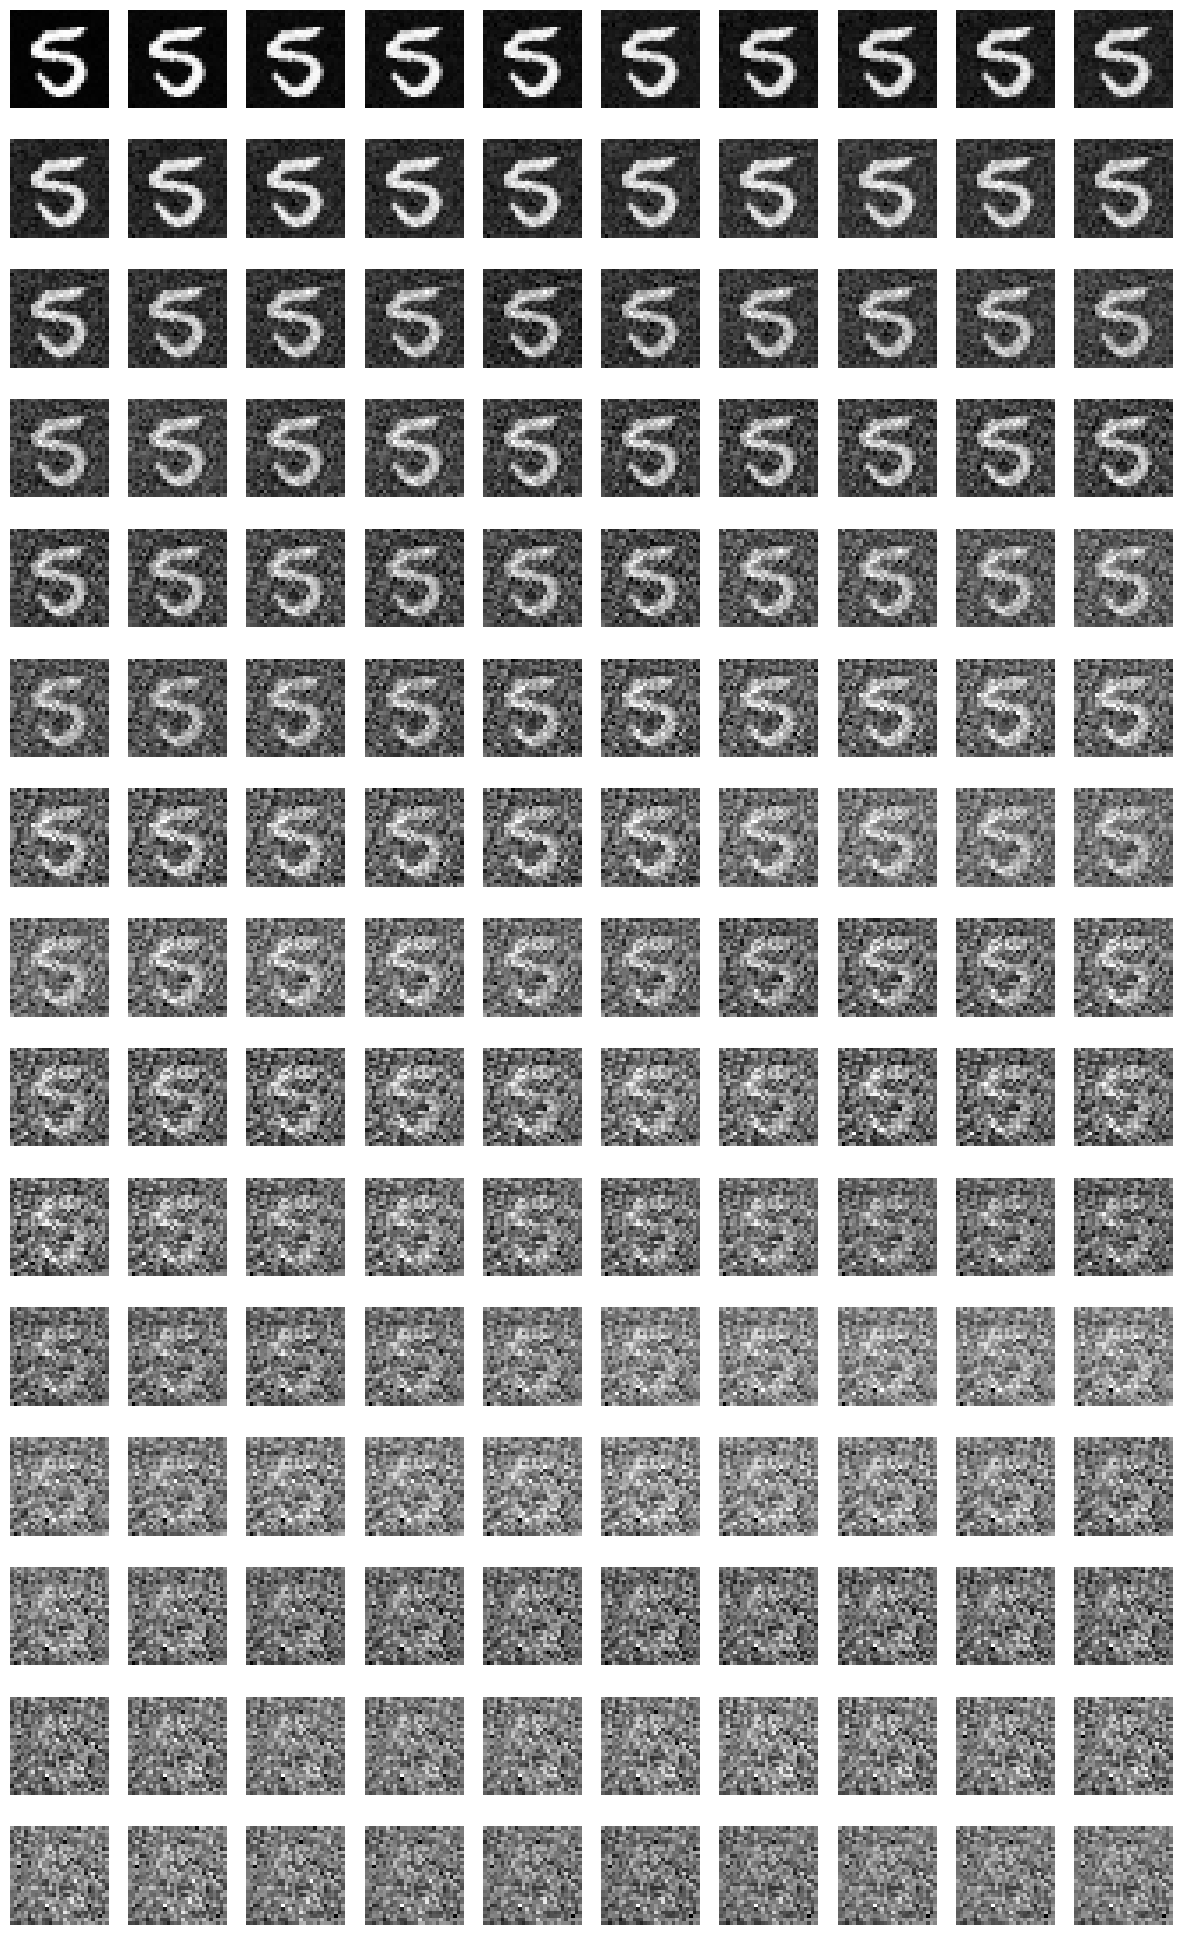

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,25))
x_0 = sample_image[0]
x_t = x_0

for t in range(T):
    noise = torch.randn_like(x_t)
    x_t = torch.sqrt(1 - B[t]) * x_t + torch.sqrt(B[t]) * noise
    img = torch.squeeze(x_t).cpu()
    ax = plt.subplot(15, 10, t + 1)
    ax.axis("off")
    plt.imshow(img, cmap="gray")

In [6]:
a = 1. - B
a_bar = torch.cumprod(a, dim=0)
sqrt_a_bar = torch.sqrt(a_bar)
sqrt_one_minus_a_bar = torch.sqrt(1 - a_bar)

In [7]:
def q(x_0, t):
    t = t.int()
    noise = torch.randn_like(x_0)
    sqrt_a_bar_t = sqrt_a_bar[t, None, None, None]
    sqrt_one_minus_a_bar_t = sqrt_one_minus_a_bar[t, None, None, None]

    x_t = sqrt_a_bar_t * x_0 + sqrt_one_minus_a_bar_t * noise
    return x_t, noise

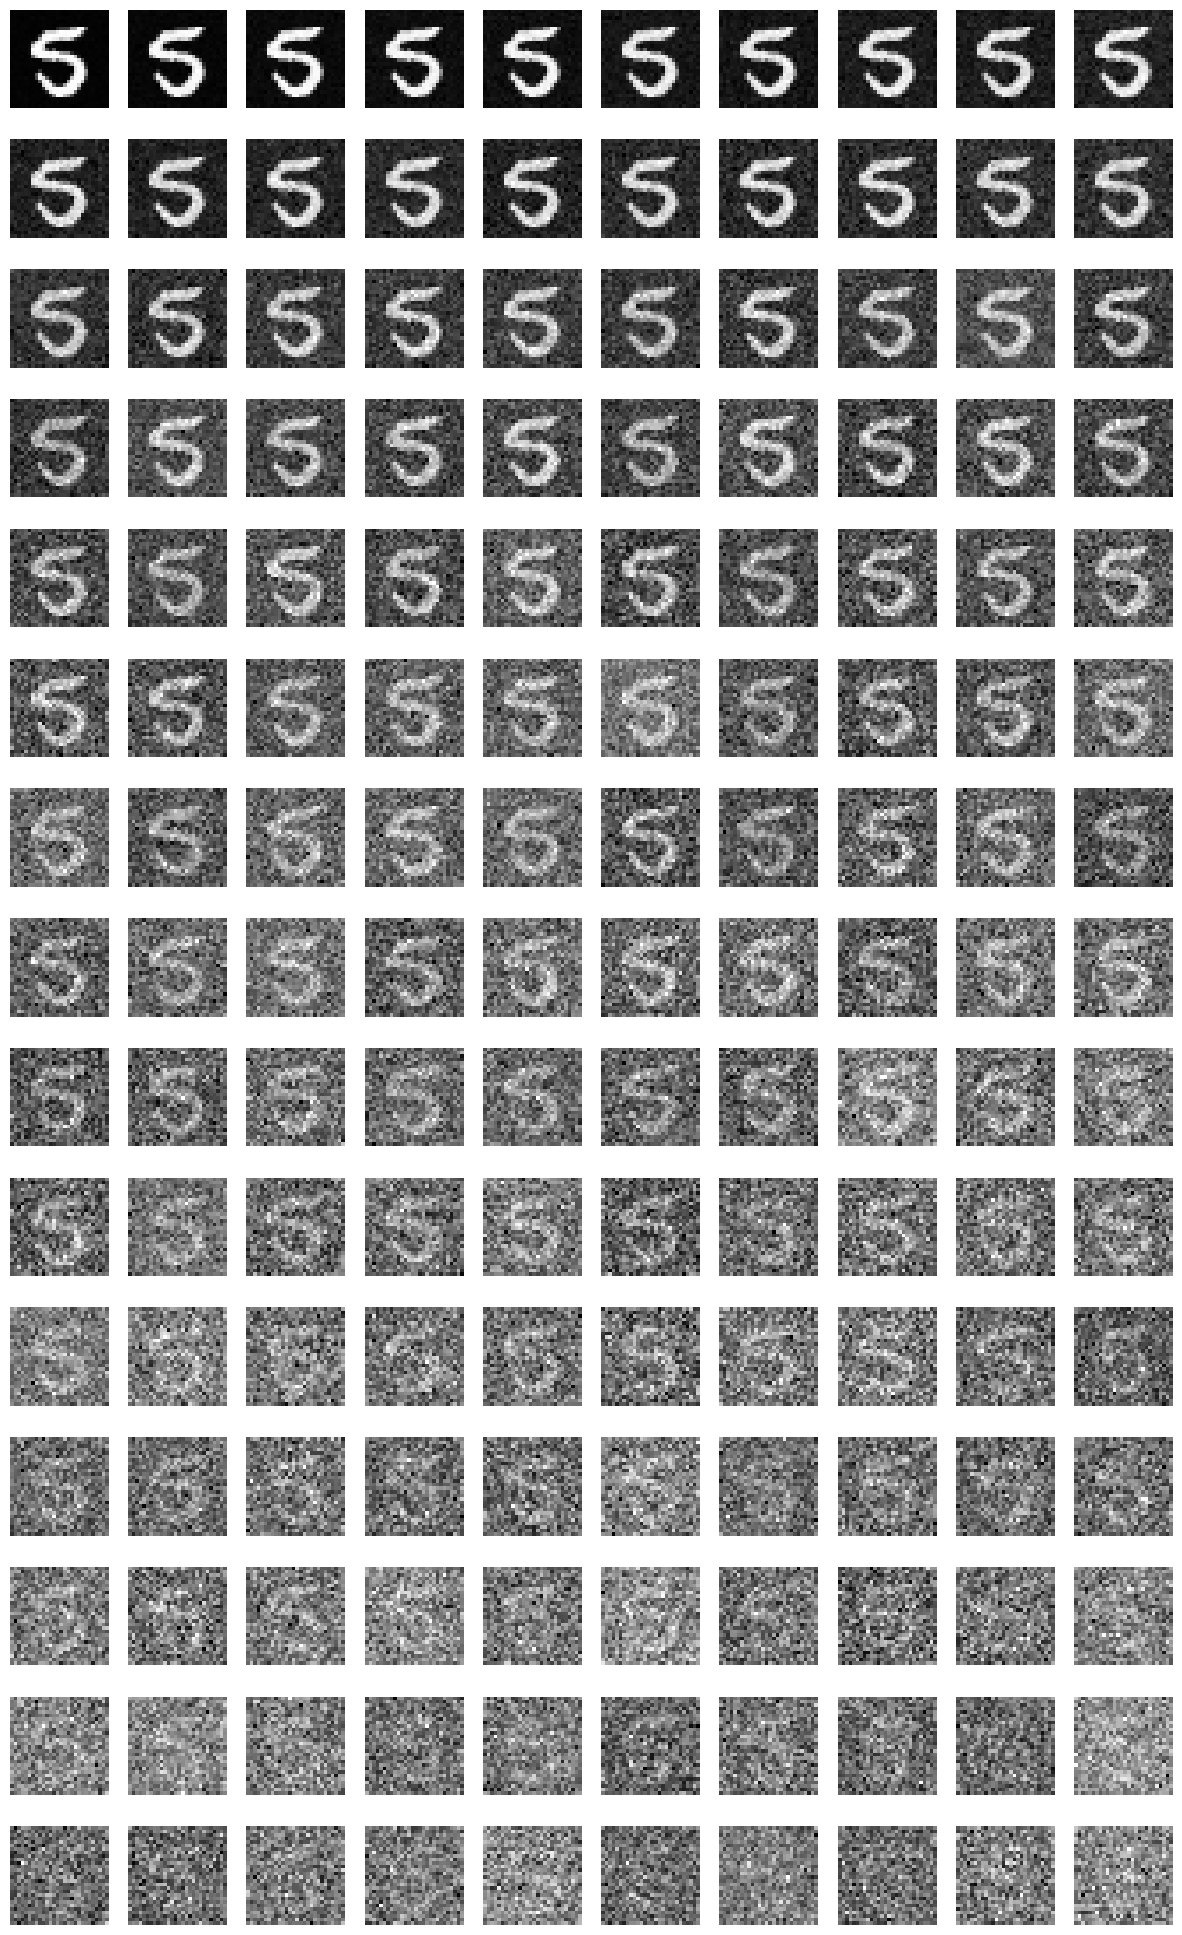

In [8]:
plt.figure(figsize=(15,25))
xs = []

for t in range(T):
    t_tenser = torch.Tensor([t]).type(torch.int64)
    x_t, _ = q(x_0, t_tenser)
    img = torch.squeeze(x_t).cpu()
    xs.append(img)
    ax = plt.subplot(15, 10, t + 1)
    ax.axis('off')
    plt.imshow(img, cmap='gray')

In [9]:
import math

In [22]:
def loss_function(model, x_0, t, label):
    x_noisy, noise = q(x_0, t)
    noise_pred = model(x_noisy, t, label)
    return F.mse_loss(noise, noise_pred)

In [43]:
class SinudoidBlock(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim

    def forward(self, time):
        device = time.device
        half = self.embedding_dim // 2
        embeddings = math.log(10000) / (half - 1)
        embeddings = torch.exp(torch.arange(half, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class TimeBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        layers = [
            nn.Linear(in_features=in_features, out_features=out_features),
            nn.ReLU(),
            nn.Linear(in_features=out_features, out_features=out_features),
            nn.Unflatten(dim=1, unflattened_size=(out_features, 1, 1)),

        ]
        self.model = nn.Sequential(*layers)

    def forward(self, input):
        input = input.view(-1, self.in_features)
        return self.model(input)


class ContextBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        layers = [
            nn.Linear(in_features=in_features, out_features=out_features),
            nn.ReLU(),
            nn.Linear(in_features=out_features, out_features=out_features),
            nn.Unflatten(dim=1, unflattened_size=(out_features, 1, 1))
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, input):
        input = input.view(-1, self.in_features)
        return self.model(input)


class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x1 = F.relu(self.bn1(self.conv1(x)))
        x2 = self.pool1(x1)
        return x1, x2
    

class UpBlock(nn.Module):
    def __init__(self, in_channels, residual_channels, out_channels):
        super().__init__()

        self.upconv1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(in_channels=in_channels + residual_channels, out_channels=out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        # self.conv2 = nn.Conv2d(in_channels=8, out_channels=out_channels//2, kernel_size=3, padding=1)


    def forward(self, x1, residual):
        x3 = self.upconv1(x1)
        x3 = torch.cat([x3, residual], dim=1)
        x4 = F.relu(self.bn1(self.conv1(x3)))
        return x4
            

class UNetSmol(nn.Module):
    def __init__(self, input_channels=1, output_channels=1):
        super().__init__()

        # Encoder
        self.down1 = DownBlock(in_channels=input_channels, out_channels=16)
        self.down2 = DownBlock(in_channels=16, out_channels=32)

        # Bottleneck
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=64)

        # Decoder
        self.up1 = UpBlock(in_channels=64, residual_channels=32, out_channels=32)
        self.up2 = UpBlock(in_channels=32, residual_channels=16, out_channels=16)
        self.conv6 = nn.Conv2d(in_channels=16, out_channels=output_channels, kernel_size=1)

        self.time_embedder = TimeBlock(in_features=1, out_features=32)
        self.time_embedder_1 = TimeBlock(in_features=32, out_features=64)
        self.time_embedder_2 = TimeBlock(in_features=32, out_features=32)
        self.label_encoder_1 = ContextBlock(in_features=10, out_features=64)
        self.label_encoder_2 = ContextBlock(in_features=10, out_features=32)


    def forward(self, x, t, labels=None):
        # Down
        x1, x2 = self.down1(x)
        x3, x4 = self.down2(x2)

        # Bottleneck
        x5 = F.relu(self.bn3(self.conv3(x4)))

        # Up
        t = self.time_embedder(t)
        time_embedding_1 = self.time_embedder_1(t)

        label_embedding_1 = self.label_encoder_1(labels)
        x5 = label_embedding_1 * x5 + time_embedding_1
        
        x6 = self.up1(x5, x3)

        time_embedding_2 = self.time_embedder_2(t)
        label_embedding_2 = self.label_encoder_2(labels)
        x6 = label_embedding_2 * x6 + time_embedding_2

        x7 = self.up2(x6, x1)
        

        x8 = self.conv6(x7)
        return x8

In [44]:
model = UNetSmol()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [45]:
sample_image, target, label = next(iter(train_loader))

t = torch.randint(0, T, (32,), device=device).float()
out = model(sample_image, t, label)
print(out.shape)

torch.Size([32, 1, 28, 28])


In [46]:
# get sample
sample_image, target, label = next(iter(train_loader))

num_epochs = 20

from tqdm import tqdm

losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for sample_image, target, label in tqdm(train_loader):
        sample_image = sample_image.to(device)
        target = target.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        t = torch.randint(0, T, (32,), device=device)
        t = t.float()
        loss = loss_function(model, sample_image, t, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        losses.append(loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


100%|██████████| 1875/1875 [05:18<00:00,  5.89it/s]


Epoch [1/20], Loss: 0.1211


100%|██████████| 1875/1875 [05:11<00:00,  6.03it/s]


Epoch [2/20], Loss: 0.0854


100%|██████████| 1875/1875 [05:14<00:00,  5.97it/s]


Epoch [3/20], Loss: 0.0785


100%|██████████| 1875/1875 [05:22<00:00,  5.81it/s]


Epoch [4/20], Loss: 0.0748


100%|██████████| 1875/1875 [05:21<00:00,  5.84it/s]


Epoch [5/20], Loss: 0.0731


100%|██████████| 1875/1875 [06:17<00:00,  4.96it/s]


Epoch [6/20], Loss: 0.0721


100%|██████████| 1875/1875 [05:37<00:00,  5.55it/s]


Epoch [7/20], Loss: 0.0703


100%|██████████| 1875/1875 [05:54<00:00,  5.29it/s]


Epoch [8/20], Loss: 0.0686


100%|██████████| 1875/1875 [05:40<00:00,  5.51it/s]


Epoch [9/20], Loss: 0.0684


100%|██████████| 1875/1875 [05:26<00:00,  5.75it/s]


Epoch [10/20], Loss: 0.0675


100%|██████████| 1875/1875 [05:53<00:00,  5.30it/s]


Epoch [11/20], Loss: 0.0666


 23%|██▎       | 425/1875 [01:22<04:40,  5.17it/s]


KeyboardInterrupt: 

In [47]:
sqrt_a_inv = torch.sqrt(1 / a)
pred_noise_coeff = (1 - a) / torch.sqrt(1 - a_bar)

In [48]:
@torch.no_grad()
def reverse_q(x_t, t, e_t):
    t = torch.squeeze(t[0].int())
    pred_noise_coeff_t = pred_noise_coeff[t]
    sqrt_a_inv_t = sqrt_a_inv[t]
    u_t = sqrt_a_inv_t * (x_t - pred_noise_coeff_t * e_t)
    if t == 0:
        return u_t
    else:
        B_t = B[t-1]
        new_noise = torch.randn_like(x_t)
        return u_t + torch.sqrt(B_t) * new_noise

In [55]:
# save model
torch.save(model.state_dict(), 'model_bigger.pth')

In [49]:
@torch.no_grad()
def sample_images(number=1):

    # generate random noise
    x_t = torch.randn(1, 1, 28, 28, device=device)
    label = torch.zeros(1, 10, device=device)
    label[0, number] = 1
    
    x_ts = []
    for i in range(0, T)[::-1]:
        t = torch.full((1,), i, device=device)
        t = t.float()
        e_t = model(x_t, t, label)
        x_t = reverse_q(x_t, t, e_t)
        x_ts.append(x_t)

    return x_ts

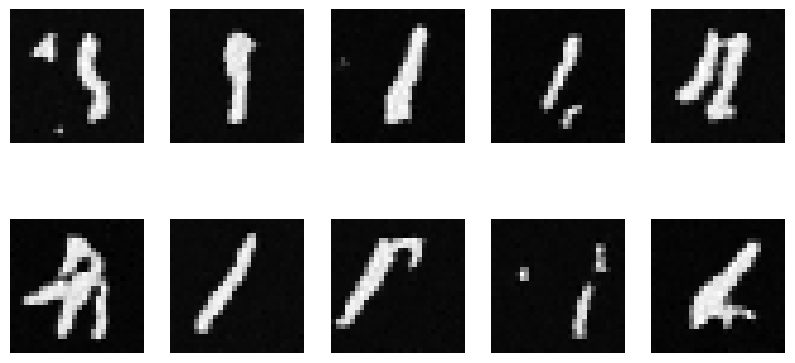

In [58]:
plt.figure(figsize=(10, 5))
model.eval()
for i in range(10):
    x_t = sample_images(number=1)[-1]
    img = torch.squeeze(input=x_t).cpu()
    ax = plt.subplot(2, 5, i + 1)
    ax.axis('off')
    plt.imshow(img, cmap='gray')


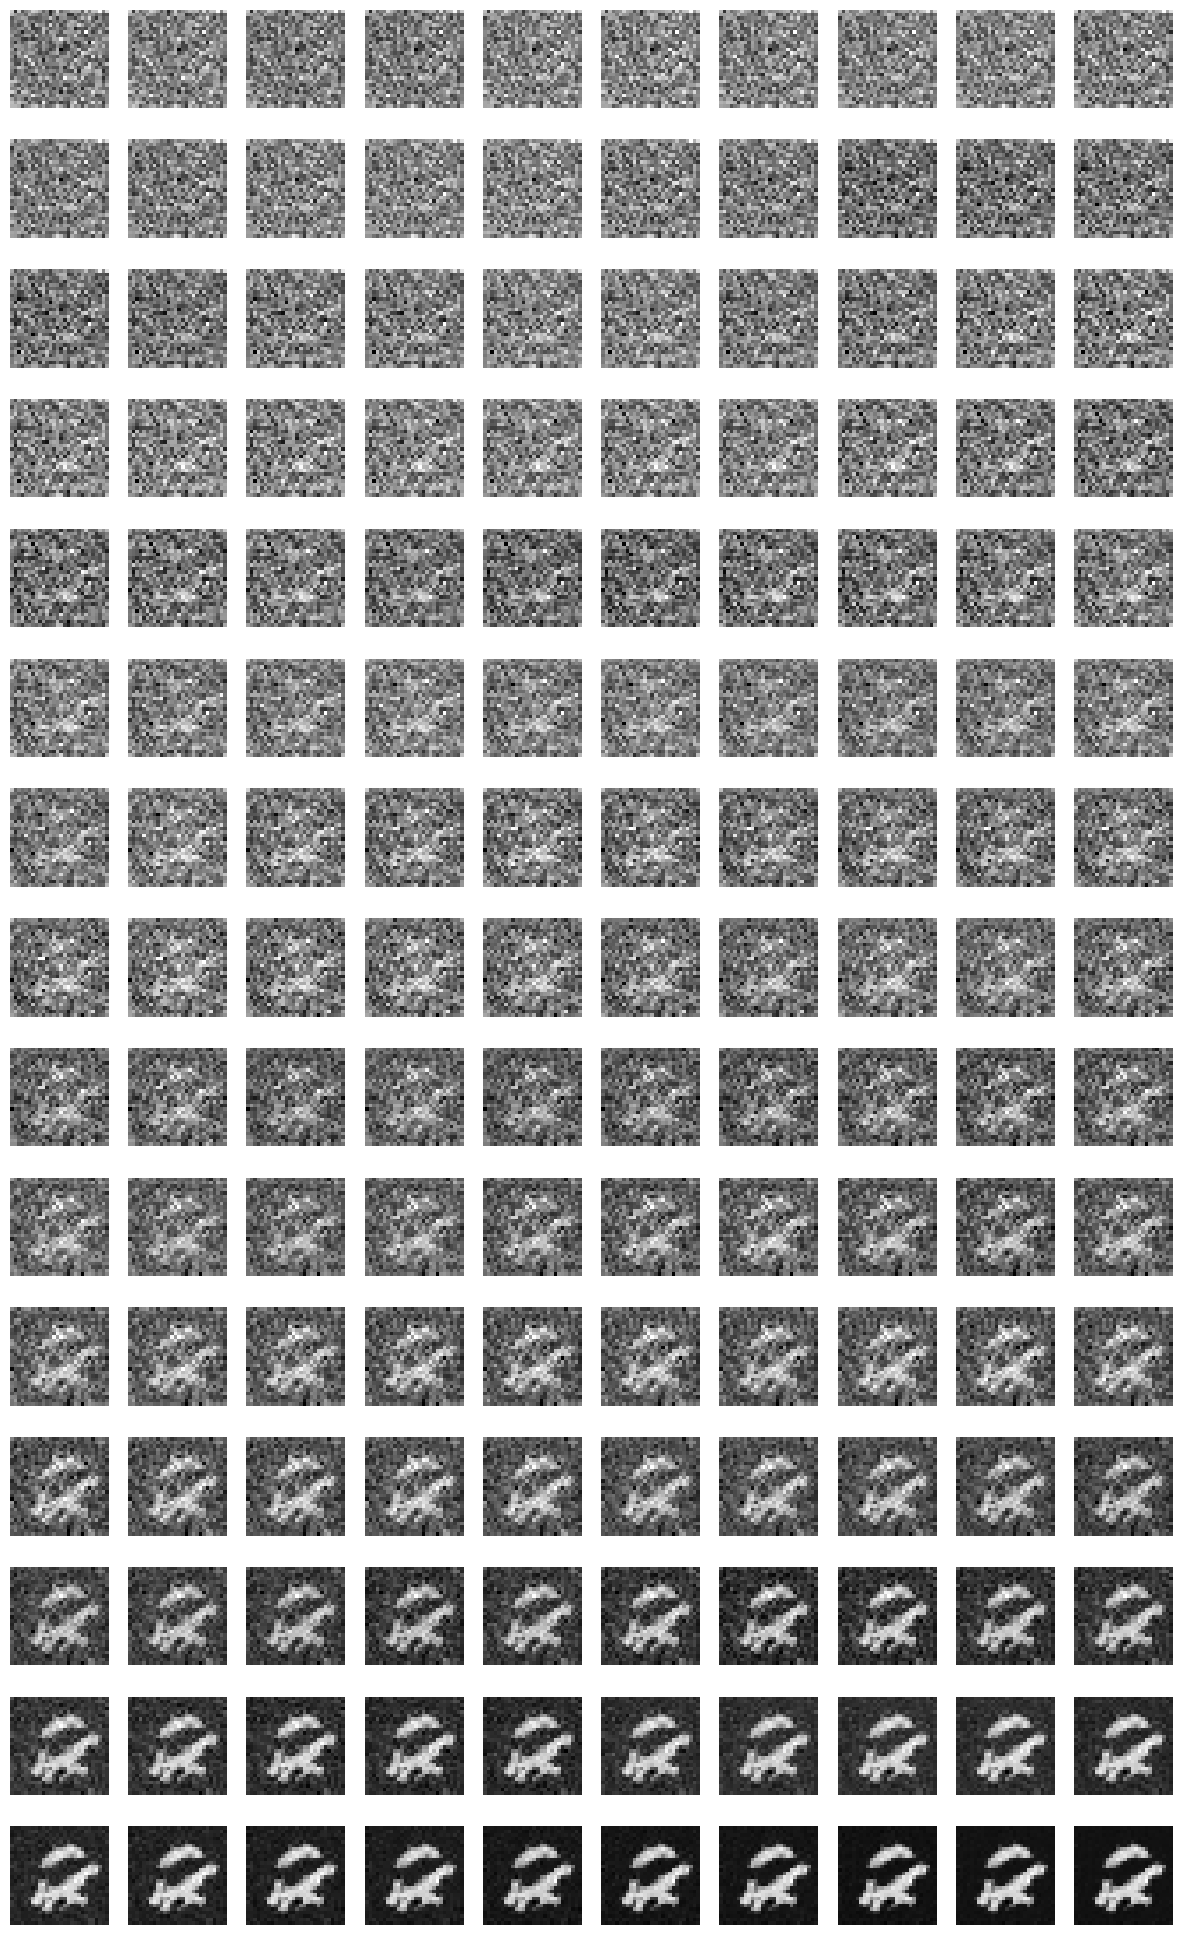

In [42]:
plt.figure(figsize=(15, 25))
x_ts = sample_images(5)

for t, x_t in enumerate(x_ts):
    img = x_t.cpu().squeeze().numpy()
    
    ax = plt.subplot(15, 10, t + 1)
    ax.axis('off')
    plt.imshow(img, cmap='gray')

In [62]:
x_ts[0].cpu().squeeze().numpy().shape

(28, 28)